# Using Natural Language Processing (NLP) to Conduct Sentiment Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import os
import plotnine as plot9
import random
import io
import graphviz # pip install graphviz
import nltk

import plotly.offline as py # pip install plotly
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
# import algorithms or functions
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from plotnine import *
from sklearn import tree
from dtreeviz.trees import *

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # pip install vaderSentiment

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
nltk.data.path.append('/nltk_data')
from nltk.stem import WordNetLemmatizer


from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS # conda install -c conda-forge wordcloud

In [3]:
sa = SentimentIntensityAnalyzer()

In [4]:
# https://www.nytimes.com/2020/07/10/dining/goya-foods-trump.html
# The comments were downloaded via the NYT Community API (deprecated)

df = pd.read_excel('/Users/kaylaburge/Downloads/comments_export2-goya-foods-trumpGroup1.xlsx')
df

,Group,commentID,status,commentSequence,userID,userDisplayName,userLocation,userTitle,userURL,picURL,...,replyCount,editorsSelection,parentID,parentUserDisplayName,depth,commentType,trusted,recommendedFlag,permID,isAnonymous
0,0,108090643,approved,108090643,84884248,Tregar,"Pacifica, ca",NaN,NaN,NaN,...,0,False,NaN,NaN,1,comment,False,0,108090643,False
1,0,108091513,approved,108091513,85661524,Mua,Transoceanic,NaN,NaN,NaN,...,0,False,NaN,NaN,1,comment,False,0,108091513,False
2,0,108092770,approved,108092770,109564112,judy🖤,Brooklyn,NaN,NaN,NaN,...,0,False,NaN,NaN,1,comment,False,0,108092770,False
3,0,108092054,approved,108092054,59802894,David,"San Francisco, CA",NaN,NaN,NaN,...,0,False,NaN,NaN,1,comment,False,0,108092054,False
4,0,108092305,approved,108092305,138114422,TX7,TX,NaN,NaN,NaN,...,0,False,NaN,NaN,1,comment,False,0,108092305,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0,108085699,approved,108085699,52147740,george eliot,"annapolis, md",NaN,NaN,NaN,...,0,False,108078253.0,Witness,2,userReply,False,0,108085699,False
212,0,108091525,approved,108091525,85661524,Mua,Transoceanic,NaN,NaN,NaN,...,0,False,108078253.0,Witness,2,userReply,False,0,108091525,False
213,0,108084047,approved,108084047,28495436,FRITZ,CT,NaN,NaN,NaN,...,0,False,108077553.0,Tuvw Xyz,2,userReply,False,0,108084047,False
214,0,108086114,approved,108086114,80656926,Barbara,"Victoria, BC",NaN,NaN,NaN,...,0,False,108084047.0,Tuvw Xyz,2,userReply,False,0,108086114,False


Now that we have the data in a data frame, let's analyze the data frame. Utilize the steps we did in an earlier effort to look at data types and missing data in each row.

In [5]:
column_headers = df.columns.values.tolist()

columns = pd.DataFrame(column_headers, columns = ['column_name'])
columnInfo = df.dtypes.to_frame('dtypes').reset_index()

missPct = df.isnull().sum()/len(df)* 100
missPct = round(missPct,0)
missPct = missPct.to_frame('missPct').reset_index()
columnInfo = pd.merge(columnInfo, missPct, how="left", on='index')
columnInfo

,index,dtypes,missPct
0,Group,int64,0.0
1,commentID,int64,0.0
2,status,object,0.0
3,commentSequence,int64,0.0
4,userID,int64,0.0
5,userDisplayName,object,0.0
6,userLocation,object,0.0
7,userTitle,float64,100.0
8,userURL,float64,100.0
9,picURL,object,94.0


The field of interest with the comments is "commentBody".

In [6]:
comments_df = df[['userID','commentID','userDisplayName','commentBody', 'commentType', 'createDate', 
                  'recommendations', 'replyCount']].copy()

comments_df

,userID,commentID,userDisplayName,commentBody,commentType,createDate,recommendations,replyCount
0,84884248,108090643,Tregar,"Labels are tricky, but Spanish people are Euro...",comment,2020-07-11 21:19:11,23,0
1,85661524,108091513,Mua,No one in their right mind who cares about chi...,comment,2020-07-11 23:24:27,163,0
2,109564112,108092770,judy🖤,I love the white trump supporters saying that ...,comment,2020-07-12 05:13:26,121,0
3,59802894,108092054,David,"It’s about time. \n\nLook, almost to a person,...",comment,2020-07-12 01:18:59,82,0
4,138114422,108092305,TX7,Remember how the Chick-fil-A boycott worked ou...,comment,2020-07-12 02:39:19,26,0
...,...,...,...,...,...,...,...,...
211,52147740,108085699,george eliot,@Witness \nNot at all. You've got to watch the...,userReply,2020-07-11 10:33:02,2,0
212,85661524,108091525,Mua,"@Witness Sorry, their products are cheap and u...",userReply,2020-07-11 23:26:13,1,0
213,28495436,108084047,FRITZ,"@Tuvw Xyz \nNo, no, and no. This is not about ...",userReply,2020-07-11 08:40:12,292,0
214,80656926,108086114,Barbara,@FRITZ Agree wholeheartedly.,userReply,2020-07-11 11:14:59,8,0


In [7]:
# corpus that contains just the comments
corpus = comments_df['commentBody']
corpus

0      Labels are tricky, but Spanish people are Euro...
1      No one in their right mind who cares about chi...
2      I love the white trump supporters saying that ...
3      It’s about time. \n\nLook, almost to a person,...
4      Remember how the Chick-fil-A boycott worked ou...
                             ...                        
211    @Witness \nNot at all. You've got to watch the...
212    @Witness Sorry, their products are cheap and u...
213    @Tuvw Xyz \nNo, no, and no. This is not about ...
214                         @FRITZ Agree wholeheartedly.
215    I see, what you’re saying is ‘it doesn’t affec...
Name: commentBody, Length: 216, dtype: object

In [8]:
# functions from 
# https://jackmckew.dev/sentiment-analysis-text-cleaning-in-python-with-vader.html

# This block does data cleaning
# comment, positive score prob, neg score prob, neutral score prob, then compound sentiment score
def get_sentiment(text:str, analyser,desired_type:str='pos'):
    # Get sentiment from text
    sentiment_score = analyser.polarity_scores(text)
    return sentiment_score[desired_type]

def get_sentiment_scores(df,data_column):
    df[f'PosSentScore'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,sa,'pos'))
    df[f'NegSentScore'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,sa,'neg'))
    df[f'NeuSentScore'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,sa,'neu'))
    df[f'CompoundSentScore'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,sa,'compound'))
    return df

In [9]:
text_sentiment = get_sentiment_scores(comments_df,'commentBody')
text_sentiment.head()

,userID,commentID,userDisplayName,commentBody,commentType,createDate,recommendations,replyCount,PosSentScore,NegSentScore,NeuSentScore,CompoundSentScore
0,84884248,108090643,Tregar,"Labels are tricky, but Spanish people are Euro...",comment,2020-07-11 21:19:11,23,0,0.000,0.162,0.838,-0.4711
1,85661524,108091513,Mua,No one in their right mind who cares about chi...,comment,2020-07-11 23:24:27,163,0,0.116,0.213,0.670,-0.9179
2,109564112,108092770,judy🖤,I love the white trump supporters saying that ...,comment,2020-07-12 05:13:26,121,0,0.199,0.000,0.801,0.8807
3,59802894,108092054,David,"It’s about time. \n\nLook, almost to a person,...",comment,2020-07-12 01:18:59,82,0,0.066,0.335,0.599,-0.9761
4,138114422,108092305,TX7,Remember how the Chick-fil-A boycott worked ou...,comment,2020-07-12 02:39:19,26,0,0.285,0.226,0.489,0.6471


In [10]:
text_sentiment['createDate'] = pd.to_datetime(text_sentiment['createDate'])
print(text_sentiment['createDate'].dtype)

datetime64[ns]


In [11]:
# https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/04-Sentiment-Analysis.html

text_sentiment = text_sentiment.set_index('createDate')
text_sentiment.sort_index()
text_sentiment

,userID,commentID,userDisplayName,commentBody,commentType,recommendations,replyCount,PosSentScore,NegSentScore,NeuSentScore,CompoundSentScore
createDate,,,,,,,,,,,
2020-07-11 21:19:11,84884248,108090643,Tregar,"Labels are tricky, but Spanish people are Euro...",comment,23,0,0.000,0.162,0.838,-0.4711
2020-07-11 23:24:27,85661524,108091513,Mua,No one in their right mind who cares about chi...,comment,163,0,0.116,0.213,0.670,-0.9179
2020-07-12 05:13:26,109564112,108092770,judy🖤,I love the white trump supporters saying that ...,comment,121,0,0.199,0.000,0.801,0.8807
2020-07-12 01:18:59,59802894,108092054,David,"It’s about time. \n\nLook, almost to a person,...",comment,82,0,0.066,0.335,0.599,-0.9761
2020-07-12 02:39:19,138114422,108092305,TX7,Remember how the Chick-fil-A boycott worked ou...,comment,26,0,0.285,0.226,0.489,0.6471
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-11 10:33:02,52147740,108085699,george eliot,@Witness \nNot at all. You've got to watch the...,userReply,2,0,0.000,0.000,1.000,0.0000
2020-07-11 23:26:13,85661524,108091525,Mua,"@Witness Sorry, their products are cheap and u...",userReply,1,0,0.159,0.071,0.769,0.3818
2020-07-11 08:40:12,28495436,108084047,FRITZ,"@Tuvw Xyz \nNo, no, and no. This is not about ...",userReply,292,0,0.121,0.065,0.814,0.9391


<Axes: xlabel='createDate'>

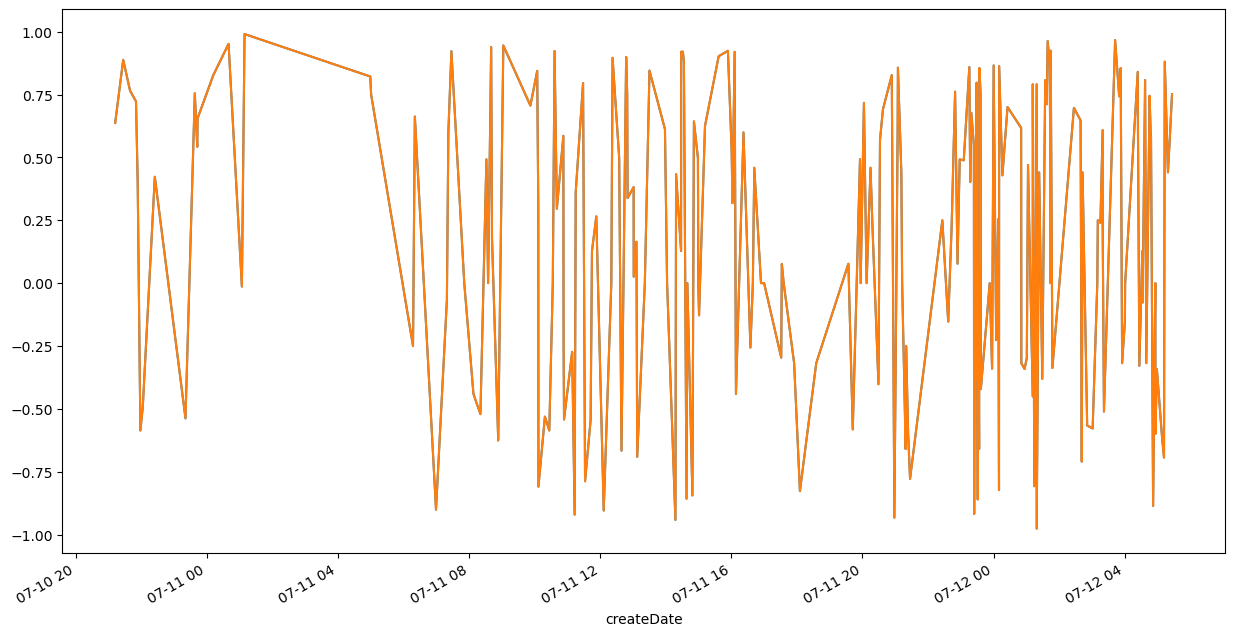

In [12]:
text_sentiment['CompoundSentScore'].plot(figsize=(15,8))
text_sentiment['CompoundSentScore'].plot()

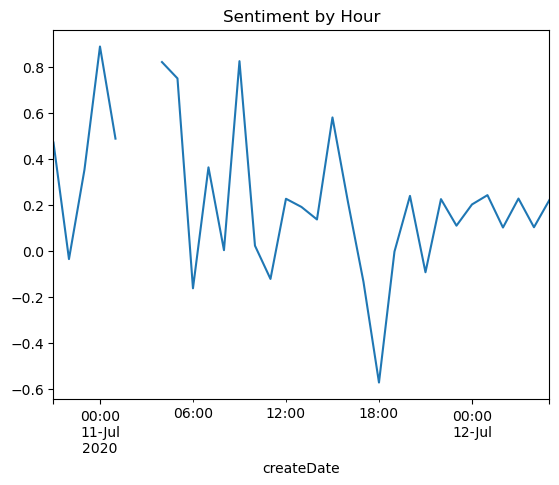

In [13]:
text_sentiment.resample('H')['CompoundSentScore'].mean().plot(
    title="Sentiment by Hour");

In [14]:
# https://www.statology.org/pandas-count-values-in-column-with-condition/
positive = len(text_sentiment[text_sentiment['CompoundSentScore']>0])
negative = len(text_sentiment[text_sentiment['CompoundSentScore']<=0])
print("Positive comments = ",positive)
print("Negative comments = ", negative)

Positive comments =  121
Negative comments =  95


In [15]:
# https://www.datasciencemadesimple.com/assign-add-new-column-dataframe-python-pandas/
df_small = {
    'Sentiment':['Positive', 'Negative'],
    'Count':[positive,negative]
}

df_small = pd.DataFrame(df_small)
df_small

,Sentiment,Count
0,Positive,121
1,Negative,95


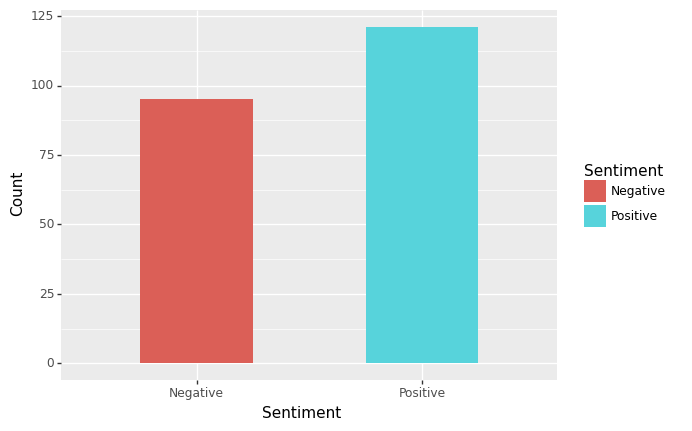

<ggplot: (333680945)>

In [16]:
(
    ggplot(df_small, aes(x = 'Sentiment', y = 'Count', fill='Sentiment')) +
    geom_bar(stat="identity", width=0.5)
)